# Market Basket Analysis

### Loading Required Libraries

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
import warnings
import collections as col
import itertools as iterto
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
import gensim

## Data Loading and Cleaning

### Reading Input Files

In [3]:
aisles = pd.read_csv('https://raw.githubusercontent.com/yashwanthky/Market_Basket_Analysis/Data_Loading/aisles_perishables_tagged.csv', index_col = 0, error_bad_lines = False).reset_index()
departments = pd.read_csv('instacart_2017_05_01/departments.csv')
products = pd.read_csv('instacart_2017_05_01/products.csv')
orders = pd.read_csv('instacart_2017_05_01/orders.csv')
orders_products_train = pd.read_csv('instacart_2017_05_01/order_products__prior.csv')  # We train the model using this data of n-1 orders
orders_products_test = pd.read_csv('instacart_2017_05_01/order_products__train.csv')   # We validate the predictions with this data of the nth order

In [5]:
aisles.head()

,aisle_id,aisle,Perishables
0,1,prepared soups salads,1
1,2,specialty cheeses,1
2,3,energy granola bars,0
3,4,instant foods,0
4,5,marinades meat preparation,1


### Data Check
#### (shape, features, unique values and missing values)

In [9]:
print ("Rows     : " ,orders.shape[0])
print ("Columns  : " ,orders.shape[1])
print ("\nFeatures : \n" ,orders.columns.tolist())
print ("\nMissing values :  ", orders.isnull().sum().values.sum())
print ("\nMissing values :  ", orders.isnull().sum().values)
print ("\nUnique values :  \n",orders.nunique())

Rows     :  3421083
Columns  :  7

Features : 
 ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']

Missing values :   206209

Missing values :   [     0      0      0      0      0      0 206209]

Unique values :  
 order_id                  3421083
user_id                    206209
eval_set                        3
order_number                  100
order_dow                       7
order_hour_of_day              24
days_since_prior_order         31
dtype: int64


There are 206,209 missing values in the column 'days_since_prior_order'. This means that these orders are the first orders for the 206,209 unique customers

In [10]:
# Let us see the order count by unique user id

print(orders.groupby('user_id').agg({'order_id' : ['count']}).min(),
      orders.groupby('user_id').agg({'order_id' : ['count']}).max(),
     orders.groupby('user_id').agg({'order_id' : ['count']}).mean(),
     orders.groupby('user_id').agg({'order_id' : ['count']}).median(),
     orders.groupby('user_id').agg({'order_id' : ['count']}).std())

order_id  count    4
dtype: int64 order_id  count    100
dtype: int64 order_id  count    16.590367
dtype: float64 order_id  count    10.0
dtype: float64 order_id  count    16.654774
dtype: float64


There are around 10 orders for 75% of the customers and the minimum number of orders per user is 4 and the maximum number of orders per user is 100.

In [11]:
print ("Rows     : " ,orders_products_train.shape[0])
print ("Columns  : " ,orders_products_train.shape[1])
print ("\nFeatures : \n" ,orders_products_train.columns.tolist())
print ("\nMissing values :  ", orders_products_train.isnull().sum().values.sum())
print ("\nUnique values :  \n",orders_products_train.nunique())

Rows     :  32434489
Columns  :  4

Features : 
 ['order_id', 'product_id', 'add_to_cart_order', 'reordered']

Missing values :   0

Unique values :  
 order_id             3214874
product_id             49677
add_to_cart_order        145
reordered                  2
dtype: int64


In [12]:
print ("Rows     : " ,orders_products_test.shape[0])
print ("Columns  : " ,orders_products_test.shape[1])
print ("\nFeatures : \n" ,orders_products_test.columns.tolist())
print ("\nMissing values :  ", orders_products_test.isnull().sum().values.sum())
print ("\nUnique values :  \n",orders_products_test.nunique())

Rows     :  1384617
Columns  :  4

Features : 
 ['order_id', 'product_id', 'add_to_cart_order', 'reordered']

Missing values :   0

Unique values :  
 order_id             131209
product_id            39123
add_to_cart_order        80
reordered                 2
dtype: int64


## Data Merging

In [5]:
merged_data = pd.merge(orders_products_train,orders, on = 'order_id')
merged_data = pd.merge(merged_data,products, on = 'product_id')
merged_data = pd.merge(merged_data,aisles, on = 'aisle_id')
merged_data = pd.merge(merged_data,departments, on = 'department_id')

Replacing the missing values in the column 'days_since_prior_order' with '999'

In [6]:
merged_data['days_since_prior_order'].fillna('999',inplace = True)

In [7]:
print ("Rows     : " ,merged_data.shape[0])
print ("Columns  : " ,merged_data.shape[1])

Rows     :  32434489
Columns  :  16


## Word2Vec Models 

Data preprocessing: converting the product_id to strings as we need to get the order length in the next steps

In [8]:
merged_data["product_id"] = merged_data["product_id"].astype(str)

#### Extract the ordered products in each order 

In [9]:
train_products = merged_data.groupby("order_id").apply(lambda order: order['product_id'].tolist())

#### Create the final sentences 

In [10]:
longest = np.max(train_products.apply(len))
sentences = train_products.values

#### Train Word2Vec model 

- I have modified the window size to be equal to the longest order in our dataset.
- Notice the usage of window = longest in the training of the model. Since there is no sequence characteristics of the products in an order 
- Because each product in an order is independent on the orders that were chosen before it in the cart- we should have a training window huge enough to accommodate all the products together or else we imply that products that are far apart even though they’re in the same cart are dissimilar which is not true.

In [11]:
model = gensim.models.Word2Vec(sentences, size=100, window=longest, min_count=2, workers=4)

#### Organize data for visualization 

In [12]:
vocab = list(model.wv.vocab.keys())

#### PCA transform the vectors into 2d 

In [13]:
pca = PCA(n_components=2)
pca.fit(model.wv.syn0)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

#### Some helpers for visualization 

In [14]:
def get_batch(vocab, model, n_batches=3):
    output = list()
    for i in range(0, n_batches):
        rand_int = np.random.randint(len(vocab), size=1)[0]
        suggestions = model.most_similar(positive=[vocab[rand_int]], topn=5)
        suggest = list()
        for i in suggestions:
            suggest.append(i[0])
        output += suggest
        output.append(vocab[rand_int])
    return output

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    """From Tensorflow's tutorial."""
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
#     plt.savefig(filename)
    plt.show()

#### Visualize a random sample 

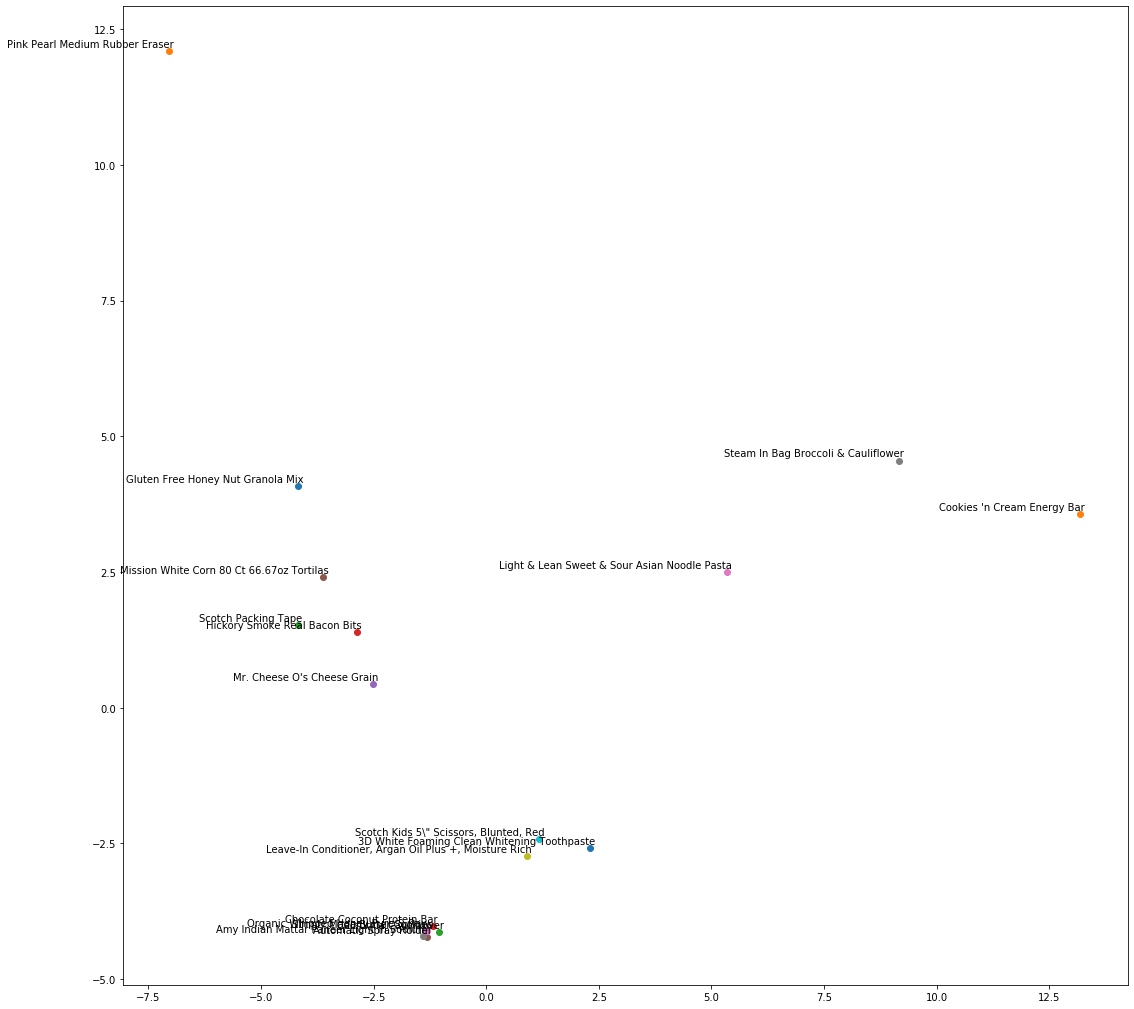

In [22]:
from IPython import embed
embeds = []
labels = []
for item in get_batch(vocab, model, n_batches=3):
    embeds.append(model[item])
    labels.append(products.loc[int(item)]['product_name'])
embeds = np.array(embeds)
embeds = pca.fit_transform(embeds)
plot_with_labels(embeds, labels)

#### Saving the model 

In [16]:
model.save("product2vec.model")